In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fine tuning models for plant disease datasets

This notebook shows you how to fine-tune CropNet models from TFHub on a dataset from TFDS or your own dataset. 

You will:
- load the TFDS cassava data or your own data,
- enrich the data with unknown (negative) examples to get a more robust model,
- apply image augmentations to the data,
- load and fine tune a CropNet model from TFHub,
- export a TFLite model, ready do be deployed on your app with MLKit (or TFLite directly).


## Imports and Dependencies

Before starting, you'll need to install some of the dependencies that will be needed like [Model Maker](https://www.tensorflow.org/lite/guide/model_maker) and the latest version of TensorFlow Datasets.

In [ ]:
!pip install tflite-model-maker
!pip install tensorflow-datasets -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 642 kB 5.0 MB/s 
     |████████████████████████████████| 238 kB 54.1 MB/s 
     |████████████████████████████████| 87 kB 8.9 MB/s 
     |████████████████████████████████| 128 kB 65.4 MB/s 
     |████████████████████████████████| 6.4 MB 62.4 MB/s 
     |████████████████████████████████| 1.1 MB 61.0 MB/s 
     |████████████████████████████████| 840 kB 67.1 MB/s 
     |████████████████████████████████| 10.9 MB 48.8 MB/s 
     |████████████████████████████████| 596 kB 65.5 MB/s 
     |████████████████████████████████| 55.3 MB 1.1 MB/s 
     |████████████████████████████████| 1.2 MB 33.2 MB/s 
     |████████████████████████████████| 3.4 MB 54.1 MB/s 
     |████████████████████████████████| 78 kB 10.0 MB/s 
     |████████████████████████████████| 25.3 MB 70.4 MB/s 
     |████████████████████████████████| 48.3 MB 96 kB/s 
     |████████████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 5.1 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


##Necessary Import

In [ ]:
import os

from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.lite.model_maker.core.export_format import ExportFormat
from tensorflow_examples.lite.model_maker.core.task import image_preprocessing
from tflite_model_maker import image_classifier
from tflite_model_maker import ImageClassifierDataLoader
from tflite_model_maker import model_spec

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


## Load a TFDS dataset to fine-tune on.

Lets use the publicly available [Cassava Leaf Disease dataset](https://www.tensorflow.org/datasets/catalog/cassava) from TFDS.

## Or alternatively load your own data to fine-tune on.
See [this](https://www.tensorflow.org/datasets/api_docs/python/tfds/folder_dataset/ImageFolder) link for supported structure of data. An example is provided using a publicly available [Cassava Leaf Disease dataset](https://www.tensorflow.org/datasets/catalog/cassava).

In [ ]:
TFLITE_NAME_PREFIX = 'katunda'
# Root dir with train, validation and test directories.
data_root_dir = '/content/drive/MyDrive/intern/katunda_dataset/combined_classification'
#data_root_dir = os.path.splitext(data_root_dir)[0]  # Remove the .zip extension

builder = tfds.ImageFolder(data_root_dir)

ds_info = builder.info
ds_train = builder.as_dataset(split='train', as_supervised=True)
ds_validation = builder.as_dataset(split='validation', as_supervised=True)
ds_test = builder.as_dataset(split='test', as_supervised=True)

## Visualize samples from train split

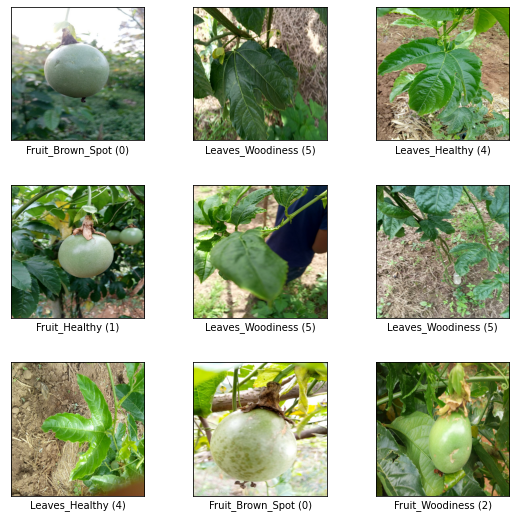

In [ ]:
_ = tfds.show_examples(ds_train, ds_info)

## Add images to be used as Unknown examples from TFDS datasets

Add additional unknown (negative) examples to the training dataset and assign a new unknown class label number to them. The goal is to have a model that when used in practice (e.g. in the field) has the option of predicting "Unknown" when it sees something unexpected.

Below you can see a list of datasets that will be used to sample the additional unknown imagery. It includes 3 completely different datasets to increase diversity. One of them is a beans leaf disease dataset, so that the model has exposure to diseased plants other than cassava.


In [ ]:
UNKNOWN_TFDS_DATASETS = [{
    'tfds_name': 'imagenet_v2/matched-frequency',
    'train_split': 'test[:80%]',
    'test_split': 'test[80%:]',
    'num_examples_ratio_to_normal': 1.0,
}, {
    'tfds_name': 'oxford_flowers102',
    'train_split': 'train',
    'test_split': 'test',
    'num_examples_ratio_to_normal': 1.0,
}, {
    'tfds_name': 'beans',
    'train_split': 'train',
    'test_split': 'test',
    'num_examples_ratio_to_normal': 1.0,
}, {
    'tfds_name': 'cassava',
    'train_split': 'train',
    'test_split': 'test',
    'num_examples_ratio_to_normal': 1.0,
}]

In [ ]:
# Load unknown datasets.
weights = [
    spec['num_examples_ratio_to_normal'] for spec in UNKNOWN_TFDS_DATASETS
]
num_unknown_train_examples = sum(
    int(w * ds_train.cardinality().numpy()) for w in weights)
ds_unknown_train = tf.data.experimental.sample_from_datasets([
    tfds.load(
        name=spec['tfds_name'], split=spec['train_split'],
        as_supervised=True).repeat(-1) for spec in UNKNOWN_TFDS_DATASETS
], weights).take(num_unknown_train_examples)
ds_unknown_train = ds_unknown_train.apply(
    tf.data.experimental.assert_cardinality(num_unknown_train_examples))
ds_unknown_tests = [
    tfds.load(
        name=spec['tfds_name'], split=spec['test_split'], as_supervised=True)
    for spec in UNKNOWN_TFDS_DATASETS
]
ds_unknown_test = ds_unknown_tests[0]
for ds in ds_unknown_tests[1:]:
  ds_unknown_test = ds_unknown_test.concatenate(ds)

# All examples from the unknown datasets will get a new class label number.
num_normal_classes = len(ds_info.features['label'].names)
unknown_label_value = tf.convert_to_tensor(num_normal_classes, tf.int64)
ds_unknown_train = ds_unknown_train.map(lambda image, _:
                                        (image, unknown_label_value))
ds_unknown_test = ds_unknown_test.map(lambda image, _:
                                      (image, unknown_label_value))

# Merge the normal train dataset with the unknown train dataset.
weights = [
    ds_train.cardinality().numpy(),
    ds_unknown_train.cardinality().numpy()
]
ds_train_with_unknown = tf.data.experimental.sample_from_datasets(
    [ds_train, ds_unknown_train], [float(w) for w in weights])
ds_train_with_unknown = ds_train_with_unknown.apply(
    tf.data.experimental.assert_cardinality(sum(weights)))

print((f"Added {ds_unknown_train.cardinality().numpy()} negative examples."
       f"Training dataset has now {ds_train_with_unknown.cardinality().numpy()}"
       ' examples in total.'))

Added 20712 negative examples.Training dataset has now 25890 examples in total.


## Apply augmentations

In [ ]:
def random_crop_and_random_augmentations_fn(image):
  # preprocess_for_train does random crop and resize internally.
  image = image_preprocessing.preprocess_for_train(image)
  image = tf.image.random_brightness(image, 0.2)
  image = tf.image.random_contrast(image, 0.5, 2.0)
  image = tf.image.random_saturation(image, 0.75, 1.25)
  image = tf.image.random_hue(image, 0.1)
  image = tf.image.random_flip_left_right(image)
  return image


def random_crop_fn(image):
  # preprocess_for_train does random crop and resize internally.
  image = image_preprocessing.preprocess_for_train(image)
  return image


def resize_and_center_crop_fn(image):
  image = tf.image.resize(image, (224, 224))
  #image = image[16:240, 16:240]
  return image


no_augment_fn = lambda image: image

In [ ]:
train_augment_fn = lambda image, label: (
    random_crop_and_random_augmentations_fn(image), label)
eval_augment_fn = lambda image, label: (resize_and_center_crop_fn(image), label)

In [ ]:
ds_train_with_unknown = ds_train_with_unknown.map(train_augment_fn)
ds_validation = ds_validation.map(eval_augment_fn)
ds_test = ds_test.map(eval_augment_fn)
ds_unknown_test = ds_unknown_test.map(eval_augment_fn)

INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


## Wrap the data into Model Maker friendly format

In [ ]:
label_names = ds_info.features['label'].names + ['UNKNOWN']

train_data = ImageClassifierDataLoader(ds_train_with_unknown,
                                       ds_train_with_unknown.cardinality(),
                                       label_names)
validation_data = ImageClassifierDataLoader(ds_validation,
                                            ds_validation.cardinality(),
                                            label_names)
test_data = ImageClassifierDataLoader(ds_test, ds_test.cardinality(),
                                      label_names)
unknown_test_data = ImageClassifierDataLoader(ds_unknown_test,
                                              ds_unknown_test.cardinality(),
                                              label_names)

In [ ]:
#@title Choose a base model

model_name = 'cropnet_cassava'  #@param ['cropnet_cassava', 'cropnet_concat', 'cropnet_imagenet', 'mobilenet_v3_large_100_224']

map_model_name = {
    'cropnet_cassava':
        'https://tfhub.dev/google/cropnet/feature_vector/cassava_disease_V1/1',
    'cropnet_concat':
        'https://tfhub.dev/google/cropnet/feature_vector/concat/1',
    'cropnet_imagenet':
        'https://tfhub.dev/google/cropnet/feature_vector/imagenet/1',
    'mobilenet_v3_large_100_224':
        'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5',
}

model_handle = map_model_name[model_name]

## Run training

TensorFlow Hub has multiple models available for Tranfer Learning.

Here you can choose one and you can also keep experimenting with other ones to try to get better results

To fine tune the model, you will use Model Maker. This is makes the overall solution easier since after the training of the model, you'll also convert it to TFLite. Model Maker makes this conversion be the best one possible and with all the necessary information for easily deploy the model later.

The model spec is where you tell Model Maker witch base model you'd like to use.

In [ ]:
image_model_spec = image_classifier.ModelSpec(uri=model_handle)

One important detail here is the `train_whole_model`. It will make the base model the fine tuned during training. This makes the process slower but the final model has a higher accuracy

In [ ]:
model = image_classifier.create(
    train_data,
    #model_spec=image_model_spec,
    batch_size=32,
    dropout_rate=0.2,
    learning_rate=0.001,
    epochs=20,
    shuffle=True,
    train_whole_model=True,
    validation_data=validation_data)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_1 (Hub  (None, 1280)             3413024   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 8967      
                                                                 
Total params: 3,421,991
Trainable params: 3,421,991
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20


809/809 [==============================] - 955s 1s/step - loss: 0.6797 - accuracy: 0.9068 - val_loss: 0.8524 - val_accuracy: 0.8200
Epoch 2/20
809/809 [==============================] - 229s 281ms/step - loss: 0.5728 - accuracy: 0.9523 - val_loss: 1.1661 - val_accuracy: 0.6785
Epoch 3/20
809/809 [==============================] - 223s 274ms/step - loss: 0.5485 - accuracy: 0.9617 - val_loss: 0.6972 - val_accuracy: 0.8846
Epoch 4/20
809/809 [==============================] - 223s 274ms/step - loss: 0.5313 - accuracy: 0.9689 - val_loss: 0.7261 - val_accuracy: 0.8677
Epoch 5/20
809/809 [==============================] - 222s 273ms/step - loss: 0.5246 - accuracy: 0.9715 - val_loss: 0.6474 - val_accuracy: 0.9169
Epoch 6/20
809/809 [==============================] - 221s 272ms/step - loss: 0.5164 - accuracy: 0.9752 - val_loss: 0.6397 - val_accuracy: 0.9215
Epoch 7/20
809/809 [==============================] - 223s 274ms/step - loss: 0.5100 - accuracy: 0.9778 - val_loss: 0.7964 - val_accuracy:

## Evaluate model on test split

In [ ]:
model.evaluate(test_data)

38/38 [==============================] - 147s 4s/step - loss: 0.6120 - accuracy: 0.9356


[0.6120305061340332, 0.9356435537338257]

Print the confusion matrix.

In [ ]:
def predict_class_label_number(dataset):
  """Runs inference and returns predictions as class label numbers."""
  rev_label_names = {l: i for i, l in enumerate(label_names)}
  return [
      rev_label_names[o[0][0]]
      for o in model.predict_top_k(dataset, batch_size=32)
  ]

In [ ]:
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

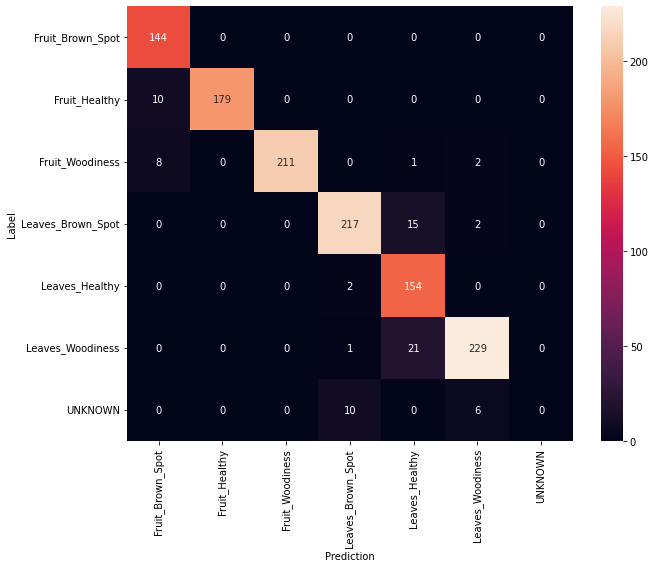

In [ ]:
confusion_mtx = tf.math.confusion_matrix(
    predict_class_label_number(test_data),
    list(ds_test.map(lambda x, y: y)),
    num_classes=len(label_names))

show_confusion_matrix(confusion_mtx, label_names)

## Evaluate model on unknown test data

In this evaluation we expect the model to have accuracy of almost 1. All images the model is tested on are not related to the normal dataset and hence we expect the model to predict the "Unknown" class label.

In [ ]:
model.evaluate(unknown_test_data)

259/259 [==============================] - 28s 105ms/step - loss: 0.4529 - accuracy: 0.9993


[0.4529215097427368, 0.9992750883102417]

Print the confusion matrix.

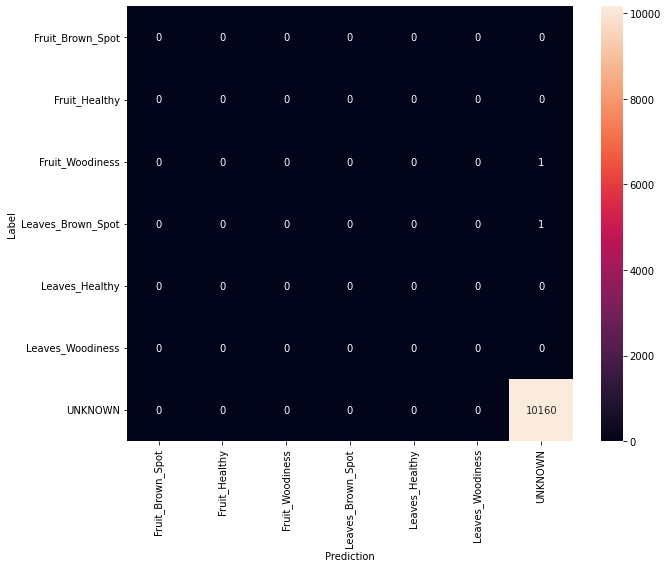

In [ ]:
unknown_confusion_mtx = tf.math.confusion_matrix(
    predict_class_label_number(unknown_test_data),
    list(ds_unknown_test.map(lambda x, y: y)),
    num_classes=len(label_names))

show_confusion_matrix(unknown_confusion_mtx, label_names)

## Export the model as TFLite and SavedModel

In [ ]:
tflite_filename = f'{TFLITE_NAME_PREFIX}_model_{model_name}.tflite'
model.export(export_dir='.', tflite_filename=tflite_filename)

INFO:tensorflow:Assets written to: /tmp/tmpt1f6zu3r/assets


INFO:tensorflow:Assets written to: /tmp/tmpt1f6zu3r/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpe3pdvmwo/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmpe3pdvmwo/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./katunda_model_cropnet_cassava.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./katunda_model_cropnet_cassava.tflite


In [ ]:
model.evaluate_tflite(tflite_filename, test_data)

{'accuracy': 0.6163648558014755}

In [ ]:
#export saved model version just in case
model.export(export_dir='/content/drive/MyDrive/intern/saved_models', export_format=ExportFormat.SAVED_MODEL)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/intern/saved_models/saved_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/intern/saved_models/saved_model/assets


## Download the TFLite model

In [ ]:
files.download(tflite_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>